In [1]:
# imports

from multipathogen_sero.io import load_metadata_json
from multipathogen_sero.config import MODEL_FITS_DIR
from multipathogen_sero.analyse_chains import *

2025-09-12 14:21:31.795 | INFO     | multipathogen_sero.config:<module>:12 - PROJ_ROOT path is: /home/ayan/sero/multipathogen-sero


In [3]:
expt_settings = load_metadata_json(MODEL_FITS_DIR / "j6318" / "a2")

idata_frailty = read_fit_csv_dir(MODEL_FITS_DIR / "j6318" / "a2" / "pairwise_serology_seroreversion_frailty")
summary = basic_summary(idata_frailty)


                        mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
baseline_hazards[0]     0.04  0.01    0.03     0.06       0.00     0.00   
baseline_hazards[1]     0.07  0.01    0.05     0.08       0.00     0.00   
seroreversion_rates[0]  0.13  0.02    0.09     0.16       0.00     0.00   
seroreversion_rates[1]  0.08  0.01    0.06     0.11       0.00     0.00   
betas[0]                0.40  0.25   -0.02     0.90       0.01     0.01   
...                      ...   ...     ...      ...        ...      ...   
log_lik_test[995]       0.00  0.00    0.00     0.00       0.00      NaN   
log_lik_test[996]       0.00  0.00    0.00     0.00       0.00      NaN   
log_lik_test[997]       0.00  0.00    0.00     0.00       0.00      NaN   
log_lik_test[998]       0.00  0.00    0.00     0.00       0.00      NaN   
log_lik_test[999]       0.00  0.00    0.00     0.00       0.00      NaN   

                        ess_bulk  ess_tail  r_hat  
baseline_hazards[0]       428.82   1122.03   1.

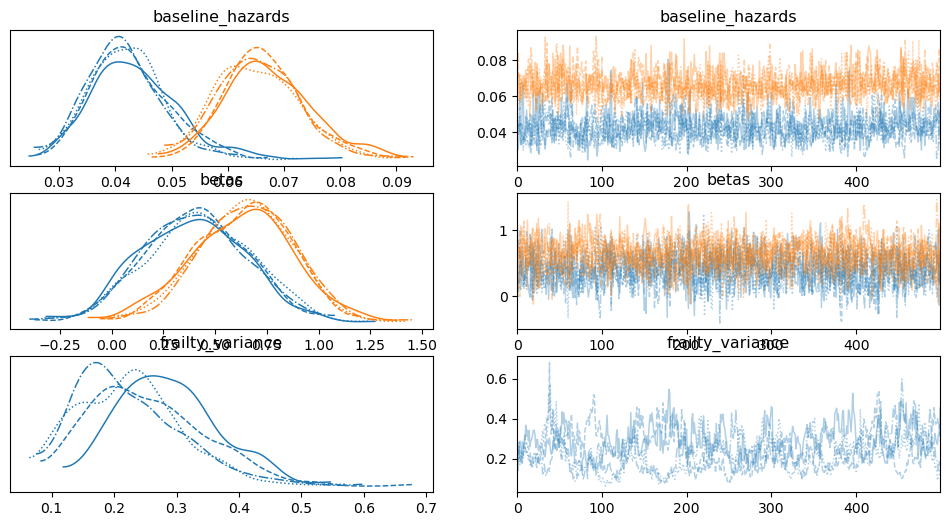

In [ ]:
axes = trace_plot(idata_frailty, var_names = ["baseline_hazards", "betas", "frailty_scale"])

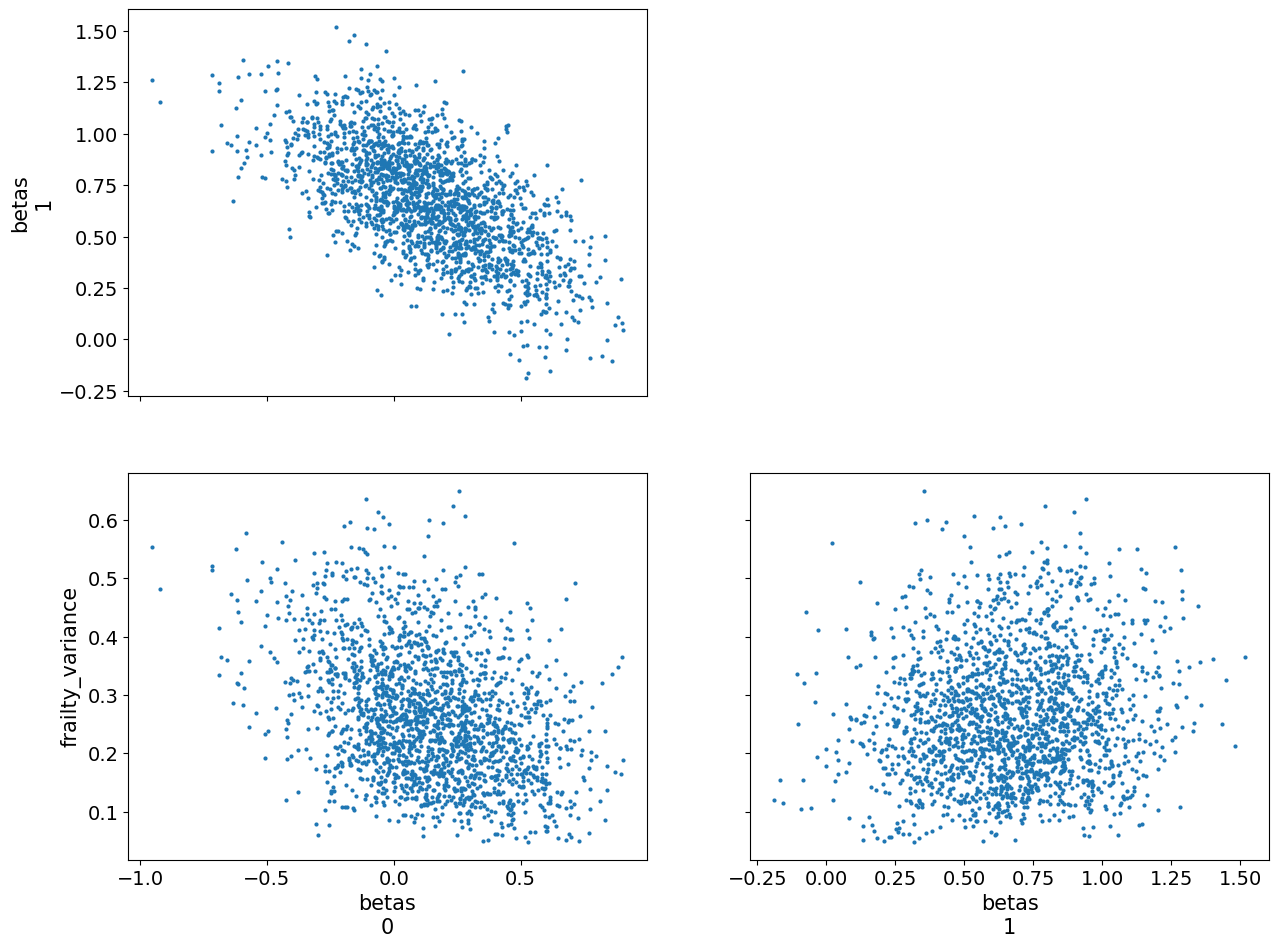

In [4]:
axes = pairs_plot(idata_frailty)

/home/ayan/sero/multipathogen-sero/multipathogen_sero/analyse_chains.py:122: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best')
/home/ayan/sero/multipathogen-sero/multipathogen_sero/analyse_chains.py:122: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best')


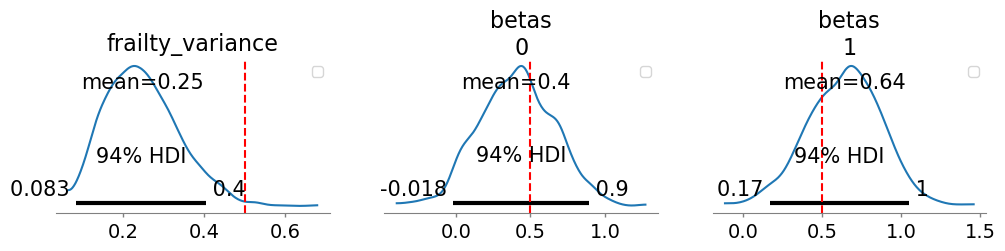

In [5]:
axes, coverage = posterior_plot(
    idata_frailty,
    var_names=["frailty_variance", "betas"],
    ground_truth={"frailty_variance": expt_settings["ground_truth_params"]["frailty_variance"], "betas": [0.5, 0.5]},
    save_dir=MODEL_FITS_DIR / "j0" / "a0" / "pairwise_serology_seroreversion_frailty",
    fig_grid=(1,3),
    fig_size=(12,2)
)

In [6]:
coverage

{'frailty_variance': [np.False_], 'betas': [np.True_, np.True_]}

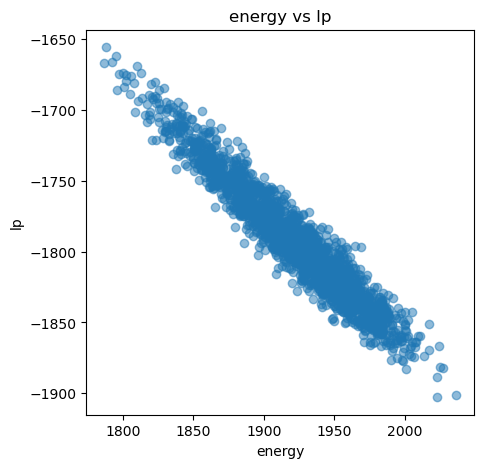

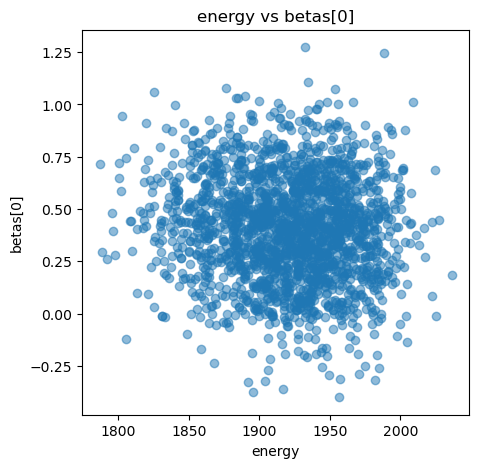

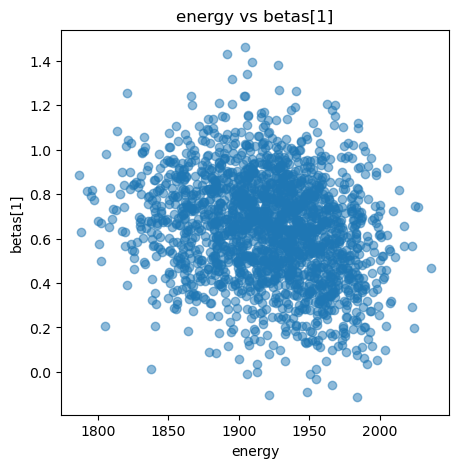

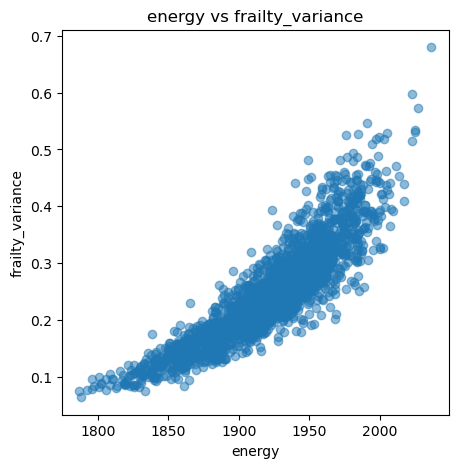

In [7]:
plot_energy_vs_lp_and_params(idata_frailty)

In [ ]:
# looping over repeats, calculate coverage

In [ ]:
# imports
import time
import os

import numpy as np
from cmdstanpy import CmdStanModel

from multipathogen_sero.io import save_metadata_json
from multipathogen_sero.config import MODEL_FITS_DIR, STAN_DIR
from multipathogen_sero.simulate import (
    get_constant_foi,
    generate_uniform_birth_times,
    simulate_infections_seroreversion,
    simulation_to_survey_wide
)
from multipathogen_sero.analyse_chains import save_fit_diagnose

# N_REPEATS = 2

ARRAY_INDEX = int(os.environ.get('SLURM_ARRAY_TASK_ID', 0))
JOB_ID = int(os.environ.get('SLURM_ARRAY_JOB_ID', 0))
HOSTNAME = os.environ.get('HOSTNAME', '')
TIMESTAMP = int(time.time()),

# initialise settings of the experiment
EXPT_SETTINGS = {
    "runtime_info": {
        "job_id": JOB_ID,
        "array_index": ARRAY_INDEX,
        "hostname": HOSTNAME,
        "timestamp": TIMESTAMP
    },
    "ground_truth_params": {
        "n_pathogens": 2,
        "baseline_hazards": [0.05, 0.10],  # TODO: choose from prior
        "seroreversion_rates": [0.1, 0.1],
        "frailty_scale": 0.5,
        "beta_mat": [[0, 0.5], [0.5, 0]],
        "seed": 42
    },
    "train_data": {
        "n_people": 250,  # TODO: make this variable
        "t_min": 0,
        "t_max": 100,
        "survey_every": 10,
        "seed": 42 + ARRAY_INDEX
    },
    "test_data": {
        "n_people": 1000,
        "t_min": 0,
        "t_max": 100,
        "survey_every": 10,
        "seed": 42 + ARRAY_INDEX
    },
    "inference_params": {
        "log_baseline_hazard_mean": -1,
        "log_baseline_hazard_scale": 1,
        "beta_scale": 1.0,
        "seroreversion_rate_scale": 1.0,
        "frailty_scale_scale": 1.0,  # only when frailty is modelled
        "n_frailty_samples": 10,  # number of Monte Carlo samples for integration over frailty
        "chains": 4,
        "iter_sampling": 500,
        "iter_warmup": 500,
        "seed": 42
    },
    "notes": ""
}

OUTPUT_DIR = MODEL_FITS_DIR / f"j{JOB_ID}" / f"a{ARRAY_INDEX}"
os.makedirs(OUTPUT_DIR, exist_ok=True)
save_metadata_json(OUTPUT_DIR, EXPT_SETTINGS)
# define the parameter grid (simulation params, random seed)

# simulate the data
birth_times = generate_uniform_birth_times(
    n_people=EXPT_SETTINGS["train_data"]["n_people"],
    t_min=EXPT_SETTINGS["train_data"]["t_min"],
    t_max=EXPT_SETTINGS["train_data"]["t_max"],
    random_seed=EXPT_SETTINGS["train_data"]["seed"]
)
foi_list = [
    get_constant_foi(a=baseline_hazard) for baseline_hazard in EXPT_SETTINGS["ground_truth_params"]["baseline_hazards"]
]


infections_df = simulate_infections_seroreversion(
    n_people=EXPT_SETTINGS["train_data"]["n_people"],
    n_pathogens=EXPT_SETTINGS["ground_truth_params"]["n_pathogens"],
    foi_list=foi_list,
    birth_times=birth_times,
    end_times=EXPT_SETTINGS["train_data"]["t_max"],
    frailty_distribution="gamma",
    frailty_scale=EXPT_SETTINGS["ground_truth_params"]["frailty_scale"],
    beta_mat=EXPT_SETTINGS["ground_truth_params"]["beta_mat"],
    seroreversion_rates=EXPT_SETTINGS["ground_truth_params"]["seroreversion_rates"],
    random_seed=EXPT_SETTINGS["ground_truth_params"]["seed"]
)

survey_every = EXPT_SETTINGS["train_data"]["survey_every"]
survey_times = {
    # i + 1: survey_every * np.arange(np.floor(birth_times[i]/survey_every)+1, np.floor(t_max/survey_every)+1)
    i + 1: np.insert(
        survey_every * np.arange(np.floor(birth_times[i] / survey_every) + 1, np.floor(EXPT_SETTINGS["train_data"]["t_max"] / survey_every) + 1),
        0, birth_times[i]
    )
    for i in range(EXPT_SETTINGS["train_data"]["n_people"])
}
survey_wide = simulation_to_survey_wide(
    infections_df,
    survey_times=survey_times
)
# exclude individuals with only one row in survey_wide
survey_wide = survey_wide.groupby('individual').filter(lambda x: len(x) > 1)
n_nontrivial_individuals = len(survey_wide['individual'].unique())

birth_times_test = generate_uniform_birth_times(
    n_people=EXPT_SETTINGS["test_data"]["n_people"],
    t_min=EXPT_SETTINGS["test_data"]["t_min"],
    t_max=EXPT_SETTINGS["test_data"]["t_max"],
    random_seed=EXPT_SETTINGS["test_data"]["seed"]
)
infections_df_test = simulate_infections_seroreversion(
    n_people=EXPT_SETTINGS["test_data"]["n_people"],
    n_pathogens=EXPT_SETTINGS["ground_truth_params"]["n_pathogens"],
    foi_list=foi_list,
    birth_times=birth_times_test,
    end_times=EXPT_SETTINGS["test_data"]["t_max"],
    frailty_distribution="gamma",
    frailty_scale=EXPT_SETTINGS["ground_truth_params"]["frailty_scale"],
    beta_mat=EXPT_SETTINGS["ground_truth_params"]["beta_mat"],
    seroreversion_rates=EXPT_SETTINGS["ground_truth_params"]["seroreversion_rates"],
    random_seed=EXPT_SETTINGS["ground_truth_params"]["seed"]
)
survey_every_test = EXPT_SETTINGS["test_data"]["survey_every"]
survey_times_test = {
    # i + 1: survey_every * np.arange(np.floor(birth_times_test[i]/survey_every)+1, np.floor(t_max/survey_every)+1)
    i + 1: np.insert(
        survey_every * np.arange(np.floor(birth_times_test[i] / survey_every) + 1, np.floor(EXPT_SETTINGS["test_data"]["t_max"] / survey_every) + 1),
        0, birth_times_test[i]
    )
    for i in range(EXPT_SETTINGS["test_data"]["n_people"])
}
survey_wide_test = simulation_to_survey_wide(
    infections_df_test,
    survey_times=survey_times_test
)
survey_wide_test = survey_wide_test.groupby('individual').filter(lambda x: len(x) > 1)
n_nontrivial_individuals_test = len(survey_wide_test['individual'].unique())

# fit both models on the data
stan_data = {
    "K": EXPT_SETTINGS["ground_truth_params"]["n_pathogens"],
    "N": n_nontrivial_individuals,
    "num_obs": survey_wide.groupby('individual').size().values,
    "num_obs_total": len(survey_wide),
    "obs_times": survey_wide['time'].values,
    "serostatus": survey_wide[[col for col in survey_wide.columns if col.startswith('serostatus_')]].values.astype(int),
    "N_test": n_nontrivial_individuals_test,
    "num_obs_test": survey_wide_test.groupby('individual').size().values,
    "num_obs_total_test": len(survey_wide_test),
    "obs_times_test": survey_wide_test['time'].values,
    "serostatus_test": survey_wide_test[[col for col in survey_wide_test.columns if col.startswith('serostatus_')]].values.astype(int),
    "n_frailty_samples": EXPT_SETTINGS["inference_params"]["n_frailty_samples"],
    "log_baseline_hazard_mean": EXPT_SETTINGS["inference_params"]["log_baseline_hazard_mean"],
    "log_baseline_hazard_scale": EXPT_SETTINGS["inference_params"]["log_baseline_hazard_scale"],
    "beta_scale": EXPT_SETTINGS["inference_params"]["beta_scale"],
    "seroreversion_rate_scale": EXPT_SETTINGS["inference_params"]["seroreversion_rate_scale"],
    "frailty_scale_scale": EXPT_SETTINGS["inference_params"]["frailty_scale_scale"]
}
model = CmdStanModel(
    stan_file=os.path.join(STAN_DIR, "pairwise_serology_seroreversion_frailty.stan")
)

14:51:26 - cmdstanpy - INFO - compiling stan file /home/ayan/sero/multipathogen-sero/multipathogen_sero/stan/pairwise_serology_seroreversion_frailty.stan to exe file /home/ayan/sero/multipathogen-sero/multipathogen_sero/stan/pairwise_serology_seroreversion_frailty


In [ ]:
fit = model.sample(
    data=stan_data,
    chains=2,
    iter_sampling=20,
    iter_warmup=20,
    parallel_chains=1,
    seed=EXPT_SETTINGS["inference_params"]["seed"],
    show_progress=True
)

13:38:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:41:52 - cmdstanpy - INFO - CmdStan done processing.
13:41:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable[15] is 0, but must be positive finite! (in 'pairwise_serology_seroreversion_frailty.stan', line 174, column 4 to column 61)
Exception: gamma_lpdf: Shape parameter is 0, but must be positive finite! (in 'pairwise_serology_seroreversion_frailty.stan', line 174, column 4 to column 61)
Consider re-running with show_console=True if the above output is unclear!
